In [3]:
# https://www.kaggle.com/kernelgenerator/titanic-tutorial-for-beginners-part-1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import re # for Regular Expressions
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from statistics import mode
from sklearn.model_selection import KFold, cross_val_score # for the cross-validation
from sklearn.preprocessing import LabelEncoder # Encoding categorical data
from sklearn.preprocessing import StandardScaler # feature scaling, normalization

%matplotlib inline 

# load training and test data
titanic = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [997]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [998]:
titanic.describe()
# see the max someone paid for a ticket was 512.3292 
# the minimum price was 0 pounds
# there is missing data since the count is lower for some cols
# the oldest passenger was 80 years old
# the youngest was only .42 years old (about 5 months).

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [999]:
titanic.Sex[titanic.Sex == 'male'].count()

577

Number of males:  577
Number of females:  314


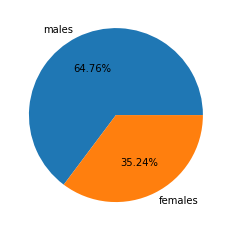

In [1000]:
males = titanic.Sex[titanic.Sex == 'male'].count()
females = titanic.Sex[titanic.Sex == 'female'].count()

print("Number of males: ",males)
print("Number of females: ",females)
plt.pie([males, females], autopct = '%.2f%%',labels=("males","females"))
plt.show()

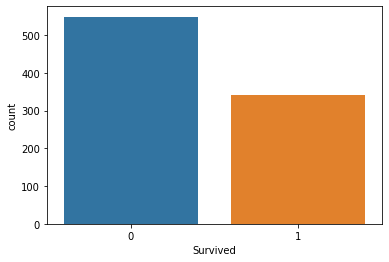

In [1001]:
#Visualize the count of number of survivors
sns.countplot(titanic['Survived'],label="Count")

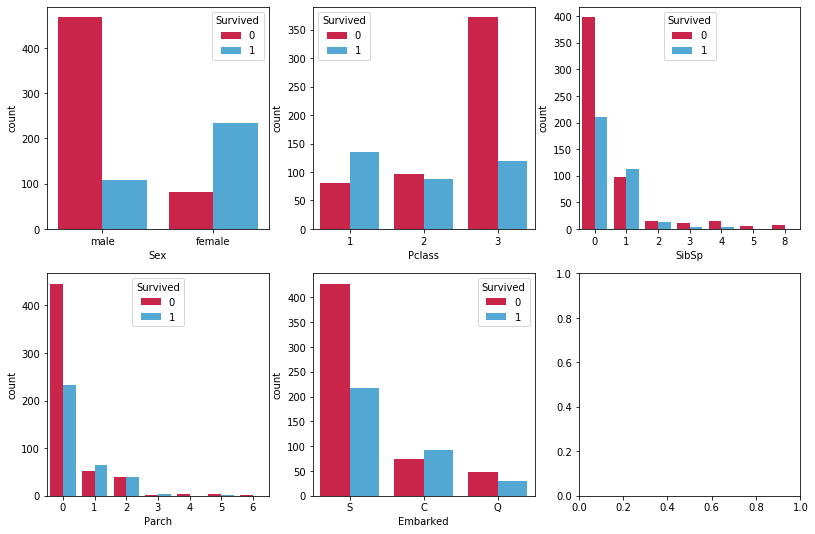

In [1002]:
columns = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
rows = 2
cols = 3

# fig is figure, the top level container for all the plot elements.
# axs is the list of subplots, an array of Axes objects
fig, axs = plt.subplots(rows, cols, figsize = (cols * 4.5, rows * 4.5) )
fig
for r in range(0, rows):
    for c in range(0, cols):
        i = r * cols + c # to address the ith subplot
        if i < (rows * cols)-1:
            subplot = axs[r][c]   # select the current subplot to draw into
            sns.countplot(titanic[columns[i]], hue=titanic['Survived'], ax=subplot, palette=["#e40a3b", "#3daee9"])
            subplot.legend(title='Survived', loc='best')

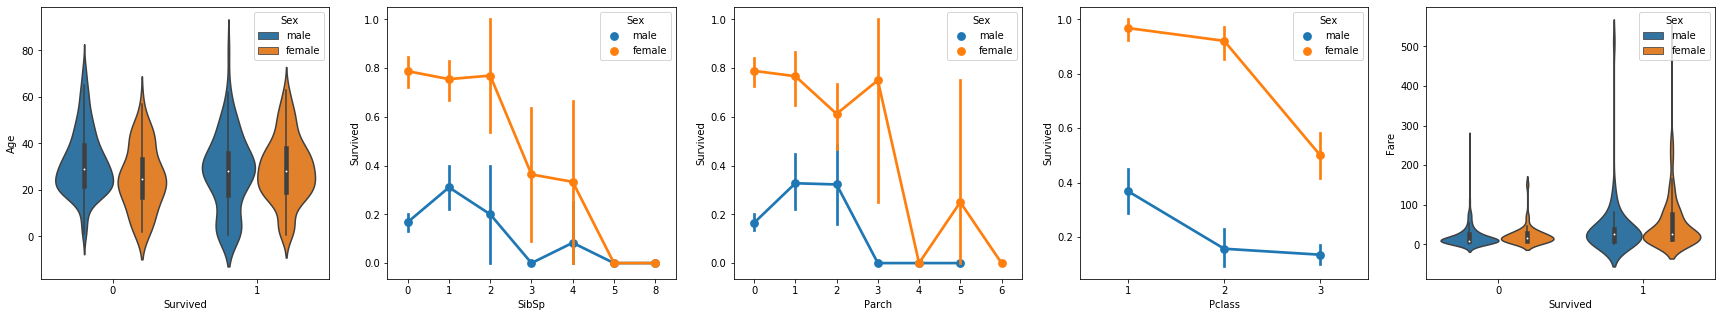

In [9]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="Survived", y="Age", hue="Sex", data=titanic, ax=axs[0])
sns.pointplot(x="SibSp", y="Survived", hue="Sex", data=titanic, ax=axs[1])
sns.pointplot(x="Parch", y="Survived", hue="Sex", data=titanic, ax=axs[2])
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=titanic, ax=axs[3])
sns.violinplot(x="Survived", y="Fare", hue="Sex", data=titanic, ax=axs[4])

In [1003]:
# create a table where columns are Class, rows are Sex
# then in each block summarize by Survival rates
titanic.pivot_table('Survived', index="Sex", columns="Pclass")

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


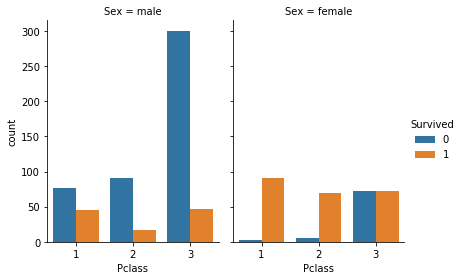

In [1004]:
# see visually who survived based on class and sex
sns.catplot(x="Pclass", hue="Survived", col="Sex",
                data=titanic, kind="count",
                height=4, aspect=.7);

In [1005]:
# Count survived females traveling on the first class
survived_first_class_females = titanic.loc[(titanic.Sex == 'female') 
            & (titanic.Pclass == 1)
            & (titanic.Survived == 1)].shape[0]

# Count females who did not survive traveling on the first class
non_survived_first_class_females = titanic.loc[(titanic.Sex == 'female') 
            & (titanic.Pclass == 1)
            & (titanic.Survived == 0)].shape[0]

print('Females who survived on first class: ', survived_first_class_females)
print('Females who did not survive on first class: ', non_survived_first_class_females)



Females who survived on first class:  91
Females who did not survive on first class:  3


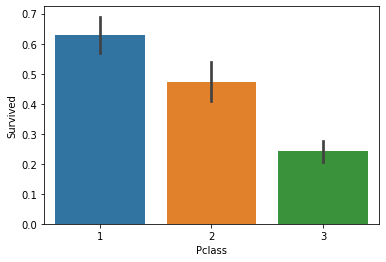

In [1006]:
#Plot the survival rate of each class.
sns.barplot(x='Pclass', y='Survived', data=titanic)

In [1007]:
#Look at survival rate by sex, age and class
age = pd.cut(titanic['Age'], [0, 18, 80])
titanic.pivot_table('Survived', ['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

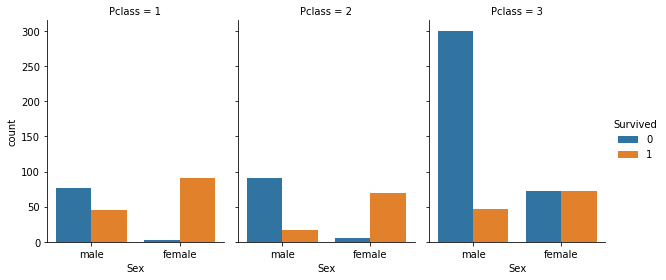

In [1008]:
# see visually who survived based on class and sex
sns.catplot(x='Sex', hue='Survived', col="Pclass",
                data=titanic, kind="count",
                height=4, aspect=.7);

Text(0.5, 1.0, 'Price for each class')

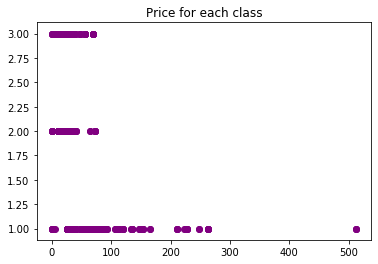

In [1009]:
plt.scatter(titanic['Fare'], titanic['Pclass'], color='purple')
plt.title('Price for each class')

In [1010]:
#Count the empty (NaN, NAN, na) values in each column 
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1011]:
# Drop the columns
titanic = titanic.drop(['Cabin', 'Ticket', 'Name'], axis=1)
#Remove the rows with missing values
titanic = titanic.dropna(subset =['Embarked', 'Age'])

# drop columns and null values from test set
test = test.drop(['Cabin', 'Ticket', 'Name'], axis=1)

In [1012]:
# check data types
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [1013]:
titanic.head

<bound method NDFrame.head of      PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    male  22.0      1      0   7.2500   
1              2         1       1  female  38.0      1      0  71.2833   
2              3         1       3  female  26.0      0      0   7.9250   
3              4         1       1  female  35.0      1      0  53.1000   
4              5         0       3    male  35.0      0      0   8.0500   
..           ...       ...     ...     ...   ...    ...    ...      ...   
885          886         0       3  female  39.0      0      5  29.1250   
886          887         0       2    male  27.0      0      0  13.0000   
887          888         1       1  female  19.0      0      0  30.0000   
889          890         1       1    male  26.0      0      0  30.0000   
890          891         0       3    male  32.0      0      0   7.7500   

    Embarked  
0          S  
1          C  
2          S  
3        

In [1014]:
# Print the unique values in columns with categorical values
print(titanic['Sex'].unique())
print(titanic['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q']


In [1015]:
labelencoder = LabelEncoder()

#Encode sex and embarked columns
titanic.loc[:,'Sex'] = labelencoder.fit_transform(titanic.loc[:,'Sex'].values)
titanic.loc[:,'Embarked'] = labelencoder.fit_transform(titanic.loc[:,'Embarked'].values)
test.loc[:,'Sex'] = labelencoder.fit_transform(test.loc[:,'Sex'].values)
test.loc[:,'Embarked'] = labelencoder.fit_transform(test.loc[:,'Embarked'].values)


In [1016]:
# Print again the unique values in columns with categorical values
print(titanic['Sex'].unique())
print(titanic['Embarked'].unique())

[1 0]
[2 0 1]


In [1017]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


In [1018]:
#Split the data into independent 'X' and dependent 'Y' variables
X_survived = titanic['Survived']
X = titanic.drop(['PassengerId', 'Survived'], axis=1) # select all columns except ids
Y = titanic.Survived # select id column

In [1019]:
# Split the dataset into 80% Training set and 20% Testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [1020]:
# Feature Scaling, this is essential to train the models fast
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1021]:
def models(X_train, Y_train):

    # Logistic Regression
    logReg = LogisticRegression(max_iter = 1000000, random_state=0)
    logReg.fit(X_train, Y_train)
    
    # K Nearest Neighbours
    knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    knn.fit(X_train, Y_train)
    
    # Support Vector Machine (linear kernel)
    svc_lin = SVC(kernel='linear', random_state=0)
    svc_lin.fit(X_train, Y_train)
    
    # Support Vector Machine (RBF kernel)
    svc_rbf = SVC(kernel='rbf', random_state=0)
    svc_rbf.fit(X_train, Y_train)
    
    # Gaussian Naive Bayes
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)
    
    # Decision Tree
    tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
    tree.fit(X_train, Y_train)
    
    # Random Forest Classifier
    forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
    forest.fit(X_train, Y_train)
    
    #Print training accuracy for each model
    print('[0] Logistic Regression Training Accuracy', logReg.score(X_train, Y_train))
    print('[1] K Nearest Neighbors Training Accuracy', knn.score(X_train, Y_train))
    print('[2] SVC Linear Training Accuracy', svc_lin.score(X_train, Y_train))
    print('[3] SVC RBF Training Accuracy', svc_rbf.score(X_train, Y_train))
    print('[4] Gaussian NB Training Accuracy', gauss.score(X_train, Y_train))
    print('[5] Decision Tree Training Accuracy', tree.score(X_train, Y_train))
    print('[6] Random Forest Training Accuracy', forest.score(X_train, Y_train))
    
    return logReg, knn, svc_lin, svc_rbf, gauss, tree, forest


In [1022]:
model = models(X_train, Y_train)

[0] Logistic Regression Training Accuracy 0.7978910369068541
[1] K Nearest Neighbors Training Accuracy 0.8664323374340949
[2] SVC Linear Training Accuracy 0.7768014059753954
[3] SVC RBF Training Accuracy 0.8506151142355008
[4] Gaussian NB Training Accuracy 0.8031634446397188
[5] Decision Tree Training Accuracy 0.9929701230228472
[6] Random Forest Training Accuracy 0.9753954305799648


In [1023]:
for i in range( len(model) ):
    print(f'Model[{i}] Testing Accuracy:' , model[i].score(X_test, Y_test))
# Logistic Regression and Random Forest performs the best on the testing data

Model[0] Testing Accuracy: 0.8111888111888111
Model[1] Testing Accuracy: 0.7832167832167832
Model[2] Testing Accuracy: 0.7902097902097902
Model[3] Testing Accuracy: 0.7972027972027972
Model[4] Testing Accuracy: 0.7482517482517482
Model[5] Testing Accuracy: 0.7762237762237763
Model[6] Testing Accuracy: 0.8041958041958042


In [1024]:
# Get feature importance
forest = model[6]
features = titanic.iloc[:,2:9].columns # select feature columns (PassengerId and Survived is omitted)
importances = pd.DataFrame({'feature': features, 'importance': np.round(forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
importances

,importance
feature,
Age,0.300
Fare,0.296
Sex,0.183
Pclass,0.098
SibSp,0.050
Parch,0.044
Embarked,0.030


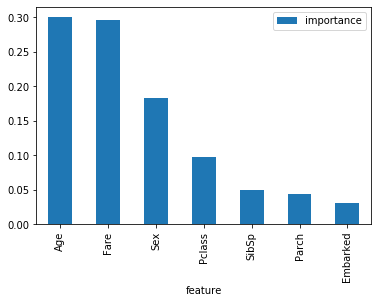

In [1025]:
importances.plot.bar()

## Preparing to save and submit results based on best model

In [1059]:
# Feature Scaling, this is essential to train the models fast
# sc = StandardScaler()
# X_full = sc.fit_transform(X)
# Y_full = sc.transform(test.drop(['PassengerId'], axis=1))
# forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
# forest.fit(X, X_survived)

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, X_survived)
    
    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [1037]:
# select Age and Fare column, and only those columns where value is null
# the fill the nulls with average values
test.loc[test.Age.isnull(), 'Age'] = test.groupby("Pclass").Age.transform('median')
test.loc[test.Fare.isnull(), 'Fare'] = test.groupby("Pclass").Fare.transform('mean')

In [1060]:
print('Training Accuracy', knn.score(X, X_survived))
test

Training Accuracy 0.7991573033707865


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,1,34.5,0,0,7.8292,1,0
1,893,3,0,47.0,1,0,7.0000,2,0
2,894,2,1,62.0,0,0,9.6875,1,0
3,895,3,1,27.0,0,0,8.6625,2,0
4,896,3,0,22.0,1,1,12.2875,2,1
...,...,...,...,...,...,...,...,...,...
413,1305,3,1,24.0,0,0,8.0500,2,0
414,1306,1,0,39.0,0,0,108.9000,0,1
415,1307,3,1,38.5,0,0,7.2500,2,0
416,1308,3,1,24.0,0,0,8.0500,2,0


In [1061]:
test['Survived'] = knn.predict(test.drop(['PassengerId', 'Survived'], axis=1))

In [1062]:
test.shape

(418, 9)

In [1063]:
test[['PassengerId', 'Survived']].to_csv('data/kaggle_submission_4.csv', index = False)